In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

from pytorch_tcn import TCN


In [ ]:
# model = TCN(
                #     num_inputs: int,
                #     num_channels: ArrayLike,
                #     kernel_size: int = 4,
                #     dilations: Optional[ ArrayLike ] = None,
                #     dilaton_reset: Optional[ int ] = None,
                #     dropout: float = 0.1,
                #     causal: bool = True,
                #     use_norm: str = 'weight_norm',
                #     activation: str = 'relu',
                #     kernel_initializer: str = 'xavier_uniform',
                #     use_skip_connections: bool = False,
                #     input_shape: str = 'NCL',
# )
# # Continue to train/use model for your task
device="cpu"
torch.set_default_dtype(torch.float64)
model = TCN(

     3, 
     [2],
     4,
     [1],
     None,
     0.1,
     True,
     'weight_norm',
     'relu',
     'xavier_uniform',
     True,
     'NLC',
)

In [ ]:
model.state_dict()

# OrderedDict([('downsample_skip_connection.0.weight',
#               tensor([[[ 1.3378],
#                        [ 0.9775],
#                        [-1.1450]],
              
#                       [[ 0.5781],
#                        [-0.3298],
#                        [-0.1334]]])),
#              ('downsample_skip_connection.0.bias', tensor([ 0.4230, -0.3506])),
#              ('downsample_skip_connection.1.weight',
#               tensor([[[ 0.0653],
#                        [ 0.4203],
#                        [-0.0121],
#                        [-0.5757]],
              
#                       [[-1.1835],
#                        [-0.0710],
#                        [-0.1189],
#                        [ 0.4266]]])),
#              ('downsample_skip_connection.1.bias', tensor([ 0.3052, -0.4861])),
#              ('network.0.conv1.bias', tensor([0.1199, 0.2118, 0.1665])),
#              ('network.0.conv1.buffer',
#               tensor([[[0., 0., 0.],
#                        [0., 0., 0.],
#                        [0., 0., 0.]]])),
# ...
#                       [[ 0.4595],
#                        [-0.3007],
#                        [ 0.3515],
#                        [ 0.2830]]])),

In [36]:

def train(input_data, model, weight_decay, learning_rate=0.001):


    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

    model.train()
    total_loss = []

    for k, (inp, label) in enumerate(input_data):  # inp = (u, x) label = x

        inp=inp.to(device)
        label=label.to(device)

        # Predict one timestep :
        output = model(inp)
        out = output[:, -1:, :]
        # reset the gradient
        
        optimizer.zero_grad()
        # calculate the error

        loss = loss_fn(out[:,-1,:], label[:, 0, 1:])
        loss.backward()
        optimizer.step()

        total_loss.append(loss.detach().cpu().numpy())

   # return the average error of the next step prediction
    return np.mean(total_loss)



In [38]:
# set some parameters for learning 
params =                     {
                           "experiment_number" : 4,
                           "window_size" : 10,
                           "h_size" : 5,
                           "l_num" : 1,
                           "epochs" : 10,
                           "learning_rate" : 0.0001,
                           "part_of_data" : 5, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.1,
                           "batch_size" : 1,
                           "future" : 4,
                           "drop_half_timesteps" : True,
                           "cut_off_timesteps" : 0
                        }

# Initialize the LSTM model
model = TCN(

     3, 
     [3, 4, 2],
     4,
     [1, 2, 4],
     None,
     0.1,
     True,
     'weight_norm',
     'relu',
     'xavier_uniform',
     True,
     'NLC',
)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data,PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = False,
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
#num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]
print(train_data.size())

data_set  = CustomDataset(train_data, window_size=params["window_size"], future=params["future"])
train_dataloader = DataLoader(data_set, batch_size=params["batch_size"], pin_memory=True, drop_last=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch = train(train_dataloader, model, params["weight_decay"], learning_rate=params["learning_rate"])#, timesteps=train_data.size(dim=1), batch_size=batch_size)
    losses.append(loss_epoch)


    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%2 == 0:
        _,_, err_train = test(input_data, model, model_type = "tcn", window_size=params["window_size"], display_plots=False, num_of_inits = 1, set_rand_seed=True, physics_rescaling = PSW_max)
        # if err_train < 3:
        #     print("stopped early")
        #     break
        _,_, err_test = test(input_data, model, model_type = "tcn", window_size=params["window_size"], display_plots=False, num_of_inits = 1, set_rand_seed=True, physics_rescaling = PSW_max)
        average_traj_err_train.append(err_train)
        average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
        print(f"Average error over full trajectories: testing data : {err_test}")

#_,_, err_test = test(input_data, model, model_type = "tcn", window_size=params["window_size"], display_plots=False, num_of_inits = 20, set_rand_seed=True, physics_rescaling = PSW_max)#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
#print(f"TRAINING FINISHED: Average error over full trajectories: training data : {err_train}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

torch.Size([4, 1100, 3])


 20%|██        | 2/10 [00:17<01:10,  8.84s/it]

Epoch: 1, the average next step error was : loss_epoch
Average error over full trajectories: training data : 0.43984278815276057
Average error over full trajectories: testing data : 0.43984278815276057


 40%|████      | 4/10 [00:34<00:52,  8.68s/it]

Epoch: 3, the average next step error was : loss_epoch
Average error over full trajectories: training data : 0.43984278815276057
Average error over full trajectories: testing data : 0.43984278815276057


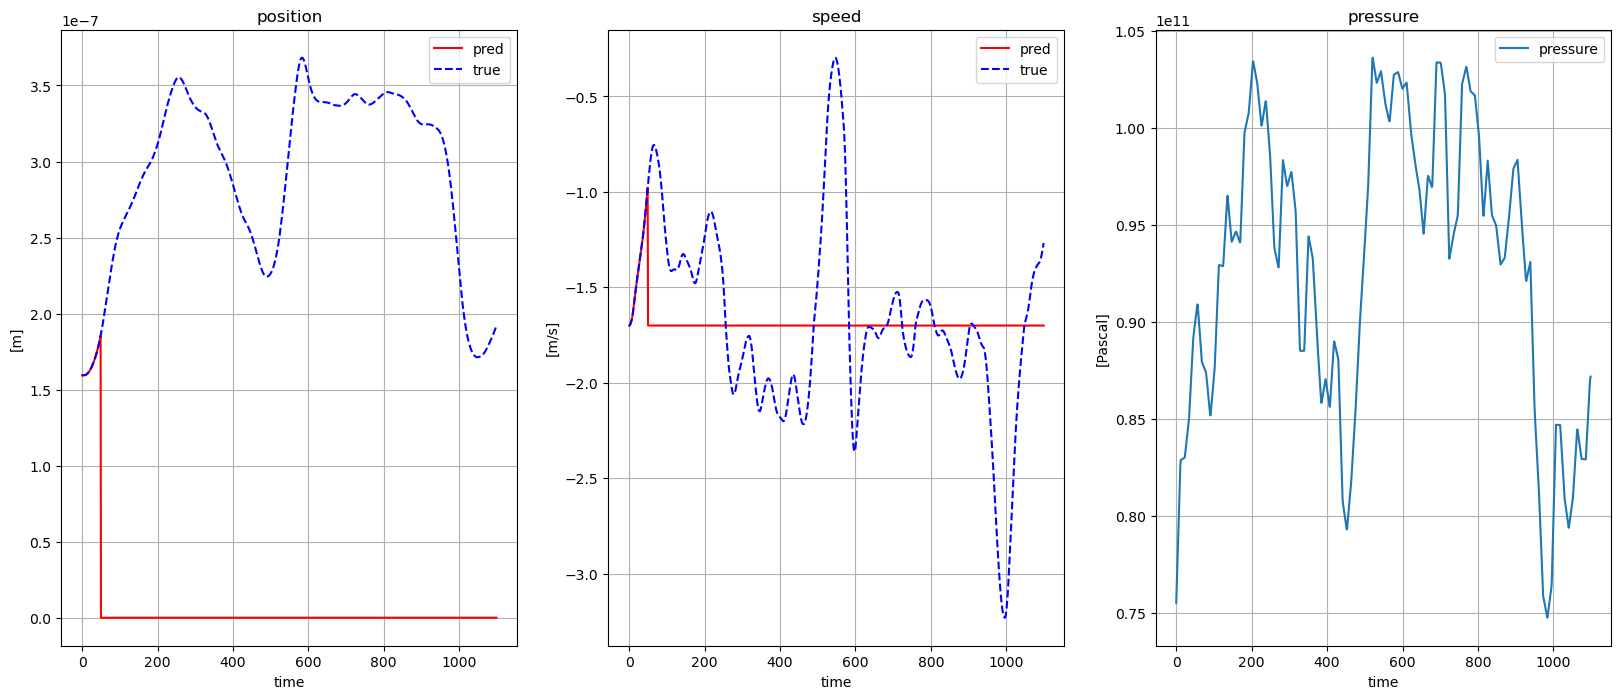

(2.409075752152995e-07, 0.02222841360589678, 0.011114327256735999)

In [32]:
test(input_data, model, model_type = "tcn", window_size=params["window_size"], display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max)